In [0]:
#@title
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [22]:
#@title Basemap installations for colab
#Basemap installations
!apt-get install -q libgeos-3.5.0
!apt-get install -q libgeos-dev
!pip install -q https://github.com/matplotlib/basemap/archive/master.zip

Reading package lists...
Building dependency tree...
Reading state information...
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists...
Building dependency tree...
Reading state information...
libgeos-dev is already the newest version (3.6.2-1build2).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 32 not upgraded.
     \ 189.5MB 127.8MB/s


In [3]:
#@title Ipywidgets install
!pip install -q ipywidgets
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [0]:
#@title Set env var
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
#@title Map packages install
!pip install -q geopandas
!pip install -q shapely
!pip install -q vincent

In [0]:
#@title Imports
#spark imports
import findspark
findspark.init()
from pyspark.sql import SparkSession

#ipywidgets imports
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

import pandas as pd
from pyspark.sql.types import IntegerType
import numpy as np

#for mapping and plots
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
%matplotlib inline

import matplotlib
matplotlib.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (16, 20)
from mpl_toolkits.basemap import Basemap

from geopandas import GeoDataFrame # Loading boundaries Data
from shapely.geometry import Point, Polygon, shape # creating geospatial data
from shapely import wkb, wkt # creating and parsing geospatial data
from ast import literal_eval as make_tuple # used to decode data from java

import folium
import vincent

from pyspark.sql.functions import col, avg
import math
import seaborn as sns

In [7]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
#!/usr/bin/python
"""BigQuery I/O PySpark example."""
from pyspark.sql import SparkSession

spark = SparkSession \
  .builder \
  .master('local[*]') \
  .appName('spark-climatechange') \
  .getOrCreate()

spark.conf.set("spark.driver.memory", '15g')
spark.conf.set("spark.driver.executer", '5g')
spark.conf.set("spark.driver.maxResultSize",'5g')
spark.conf.set("spark.sql.broadcastTimeout", '36000')

In [9]:
#@title Load data and create views

def performPreProcessing(df):
  #casting year, month and day to integer values
  df = df.withColumn("year", df["year"].cast(IntegerType()))
  df = df.withColumn("mo", df["mo"].cast(IntegerType()))
  df = df.withColumn("da", df["da"].cast(IntegerType()))
  #df = df.filter("temp" != '9999.')
  return df
  
#utility funtion that loads data from year 2009 to 2019, performs pre-processing on dataframes and create views
def load_datasets_and_set_views():
  global stations, gsod_data_2009, gsod_data_2010, gsod_data_2011, gsod_data_2012, gsod_data_2013, gsod_data_2014, gsod_data_2015, gsod_data_2016, gsod_data_2017, gsod_data_2018, gsod_data_2019
  
  stations = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/stations.txt").cache()
  stations = stations.dropDuplicates(['usaf'])
  stations.createOrReplaceTempView("stations")

  gsod_data_2009 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2009.txt").cache()
  performPreProcessing(gsod_data_2009)
  gsod_data_2009.createOrReplaceTempView("gsod_data_2009")

  gsod_data_2010 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2010.txt").cache()
  performPreProcessing(gsod_data_2010)
  gsod_data_2010.createOrReplaceTempView("gsod_data_2010")

  gsod_data_2011 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2011.txt").cache()
  performPreProcessing(gsod_data_2011)
  gsod_data_2011.createOrReplaceTempView("gsod_data_2011")

  gsod_data_2012 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2012.txt").cache()
  performPreProcessing(gsod_data_2012)
  gsod_data_2012.createOrReplaceTempView("gsod_data_2012")

  gsod_data_2013 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2013.txt").cache()
  performPreProcessing(gsod_data_2013)
  gsod_data_2013.createOrReplaceTempView("gsod_data_2013")

  gsod_data_2014 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2014.txt").cache()
  performPreProcessing(gsod_data_2014)
  gsod_data_2014.createOrReplaceTempView("gsod_data_2014")

  gsod_data_2015 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2015.txt").cache()
  performPreProcessing(gsod_data_2015)
  gsod_data_2015.createOrReplaceTempView("gsod_data_2015")

  gsod_data_2016 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2016.txt").cache()
  performPreProcessing(gsod_data_2016)
  gsod_data_2016.createOrReplaceTempView("gsod_data_2016")

  gsod_data_2017 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2017.txt").cache()
  performPreProcessing(gsod_data_2017)
  gsod_data_2017.createOrReplaceTempView("gsod_data_2017")

  gsod_data_2018 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2018.txt").cache()
  performPreProcessing(gsod_data_2018)
  gsod_data_2018.createOrReplaceTempView("gsod_data_2018")

  gsod_data_2019 = spark.read.format("csv").option("header", "true").load("/content/gdrive/My Drive/climate-dataset/gsod2019.txt").cache()
  performPreProcessing(gsod_data_2019)
  gsod_data_2019.createOrReplaceTempView("gsod_data_2019")

  print("done")

load_datasets_and_set_views()

done


In [0]:
#@title Filter US stations in all tables
#filter only US states
def filter_US_add_state(table_name):
  #chosing only US country
  new_df = spark.sql("SELECT * from {} g WHERE g.stn IN (SELECT stations.usaf from stations WHERE stations.country = 'US')".format(table_name))
  return new_df

gsod_data_2009 = filter_US_add_state("gsod_data_2009")
gsod_data_2009.createOrReplaceTempView("gsod_data_2009")

gsod_data_2010 = filter_US_add_state("gsod_data_2010")
gsod_data_2010.createOrReplaceTempView("gsod_data_2010")

gsod_data_2011 = filter_US_add_state("gsod_data_2011")
gsod_data_2011.createOrReplaceTempView("gsod_data_2011")

gsod_data_2012 = filter_US_add_state("gsod_data_2012")
gsod_data_2012.createOrReplaceTempView("gsod_data_2012")

gsod_data_2013 = filter_US_add_state("gsod_data_2013")
gsod_data_2013.createOrReplaceTempView("gsod_data_2013")

gsod_data_2014 = filter_US_add_state("gsod_data_2014")
gsod_data_2014.createOrReplaceTempView("gsod_data_2014")

gsod_data_2015 = filter_US_add_state("gsod_data_2015")
gsod_data_2015.createOrReplaceTempView("gsod_data_2015")

gsod_data_2016 = filter_US_add_state("gsod_data_2016")
gsod_data_2016.createOrReplaceTempView("gsod_data_2016")

gsod_data_2017 = filter_US_add_state("gsod_data_2017")
gsod_data_2017.createOrReplaceTempView("gsod_data_2017")

gsod_data_2018 = filter_US_add_state("gsod_data_2018")
gsod_data_2018.createOrReplaceTempView("gsod_data_2018")

gsod_data_2019 = filter_US_add_state("gsod_data_2019")
gsod_data_2019.createOrReplaceTempView("gsod_data_2019")

In [0]:
#@title Dropdown Display Options - Processing
#Step 1:
#Give a dropdown with dynamically populated US states
states = spark.sql("SELECT distinct(state) AS STATE_ABBR from stations WHERE country == 'US'")
states = states.filter(states.STATE_ABBR != 'null')
state_list = states.toPandas()

#US state names and corresponding abbreviation
usa = gpd.read_file('/content/gdrive/My Drive/states_21basic/states.shp')

state_names = pd.merge(state_list, usa, on='STATE_ABBR').filter(['STATE_ABBR','STATE_NAME'])
state_names['name_abb'] = state_names[['STATE_NAME','STATE_ABBR']].apply(tuple, axis=1)
state_names.head()

#dictionary with month number as key and month as value - to make display better
month_dict = { 1:'January' , 2:'February', 3:'March', 4:'April', 5:'May', 6:'June', 7:'July', 8:'August', 9:'September', 10:'October', 11:'November', 12:'December'}
#form state dictionary - key - Abb val- name
state_dict = {}
for index, row in state_names.iterrows():
  state_dict[row['STATE_ABBR']] = row['STATE_NAME']

years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]

In [0]:
#@title Function Definitions
#Implement - use dropdwon options as a list of unique states in US and month
def showSelectionOptions():
  months = [('Jan', 1),('Feb', 2),('Mar',3),('Apr',4),('May',5),('Jun', 6),('Jul',7),('Aug',8),('Sep',9),('Oct',10),('Nov',11),('Dec',12)]
  state_options = widgets.Dropdown(
          options = list(state_names['name_abb']),
          description='Location:'
          )

  #state_options.observe(on_change_state)

  display(state_options)

  month_options = widgets.Dropdown(
          options=months, 
          description='Month:'
          )

  #month_options.observe(on_change_month)
  display(month_options)
  return state_options, month_options

#store chosen values in variables - now not needed as state column is added to gsod tables
def filterOnState(state_options):
  state_chosen = state_options.value
  print(state_chosen)
  #get all stations of chosen state
  filtered_stations = spark.sql("SELECT usaf, name, lat, lon, state FROM stations WHERE state == '{}'".format(state_chosen))
  
  filtered_stations = filtered_stations.withColumnRenamed("usaf","stn")
  #stations that are very close by have same stn key - keep one and delete duplicates
  #filtered_stations = filtered_stations.dropDuplicates(['stn'])
  filtered_stations.createOrReplaceTempView("filtered_stations")
  return filtered_stations

#iterate through each climate table and return average temp over chosen month
def get_average_temp(table_name, year, month_chosen):
  if month_chosen >= 10:
    temp_df = spark.sql("SELECT t.stn, AVG(t.temp) AS avg_temp_{}, MIN(t.min) as min_temp_{} , MAX(t.max) as max_temp_{} FROM {} AS t INNER JOIN filtered_stations AS f ON f.stn == t.stn WHERE t.mo == '{}' and t.temp != '9999.9' and t.min != '9999.9' and t.max != '9999.9' GROUP BY t.stn ORDER BY t.stn".format(year, year, year, table_name, month_chosen))
  else:
    temp_df = spark.sql("SELECT t.stn, AVG(t.temp) AS avg_temp_{}, MIN(t.min) as min_temp_{} , MAX(t.max) as max_temp_{} FROM {} AS t INNER JOIN filtered_stations AS f ON f.stn == t.stn WHERE t.mo == '0{}' and t.temp != '9999.9' and t.min != '9999.9' and t.max != '9999.9' GROUP BY t.stn ORDER BY t.stn".format(year, year, year, table_name, month_chosen))
  
  #find average by group by station
  temp_df.createOrReplaceTempView("temp_df")
  #temp_df = spark.sql("SELECT stn, AVG(temp) AS avg_temp_{}, MIN(min) as min_temp_{} , MAX(max) as max_temp_{} FROM temp_df GROUP BY stn".format(year, year, year))
  #temp_df.show(5)
  return temp_df

#iterate over the years and join average tempeartures over new year to existing dataframe
def getAverageTempforMonth(filtered_stations, month_chosen):
  years = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]
  for year in years:
    if year == 2019 and month_chosen == 12:
      #do nothing as data not available
      pass
    else:
      table_name = "gsod_data_"+str(year)
      #call function that returns average temp of the month
      tdf = get_average_temp(table_name, year, month_chosen)
      filtered_stations = filtered_stations.join(tdf, on = "stn", how= "inner").cache()# this function not returning all stations of the state which means the temp data is missing

  return filtered_stations

In [13]:
#@title Show Form
state_options, month_options = showSelectionOptions()

Dropdown(description='Location:', options=(('South Carolina', 'SC'), ('Arizona', 'AZ'), ('Louisiana', 'LA'), (…

Dropdown(description='Month:', options=(('Jan', 1), ('Feb', 2), ('Mar', 3), ('Apr', 4), ('May', 5), ('Jun', 6)…

In [14]:
filtered_stations = filterOnState(state_options)

state_chosen = state_options.value
month_chosen = month_options.value

SC


In [15]:
vars = ['Average Temperature', 'Maximum Temperature', 'Minimum Temperature', 'Windspeed', 'Visibility']
var_options = widgets.Dropdown(
        options = vars,
        description='Select Variable:'
        )
display(var_options)

Dropdown(description='Select Variable:', options=('Average Temperature', 'Maximum Temperature', 'Minimum Tempe…

# **HEAT MAP:**

*   Average values(here temperature) for all months from January to December
*   Idea about how variables are dependent on the month and if they change over time


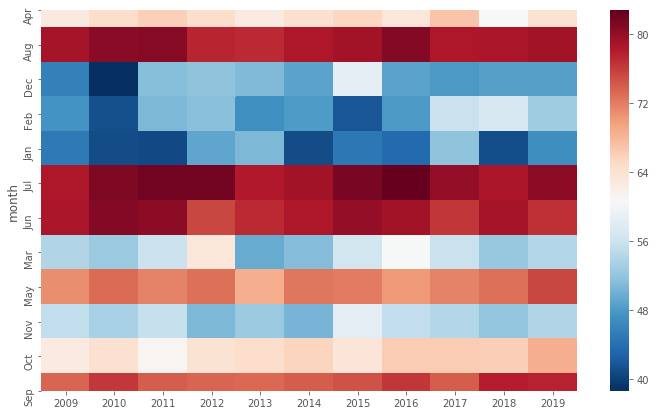

In [16]:
#@title Heat Map
#get avg temp of all
heat_map = pd.DataFrame()

def get_temp_avg(table_name):
  o = spark.sql("SELECT g.year, g.mo, g.temp, f.state FROM {} g INNER JOIN filtered_stations f ON f.stn = g.stn WHERE g.temp != '9999.9'".format(table_name))
  #max_avg_jun.append(o.groupBy('mo').agg({'temp':'avg'}).collect()[0]['avg(temp)'])
  heat_map[year] = o.groupBy('mo').agg({'temp':'avg'}).orderBy('mo').select('avg(temp)').repartition(1).toPandas()['avg(temp)']

for year in years:
  table_name = "gsod_data_"+str(year)
  get_temp_avg(table_name)

#processing for Dec 2019 
heat_map[2019][11] = heat_map[2018][11]
heat_map['month'] = ['Jan' , 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#prepare input for seaborn heatmap 
pvsummer = pd.pivot_table(heat_map, index='month')

plt.figure(figsize=(12,7))
sns.heatmap(pvsummer, cmap = "RdBu_r")
plt.show()

# **Insights**

For Michigan State:
1.   (Dec Jan Feb) are coldest months and (Jun, Jul, Aug) are the hottest months.
2.   Relatively Hot Summers in 2010, 2012, 2016.
3.   Relatively Cold Winter in 2014 and 2015.

# **OCCURRENCE OF EVENTS FROM 2009 to 2019** 

*   Thunderstorm, Rain, Fog, Tornado, Hail
*   Sum of occurence of the event over US from 2009 to 2019
*   Trend in the occurence can be effected due to climate change




In [0]:
#@title Spark SQL Processing
#thuderstorm analysis over the years
thunderstorms_count = []
hailstorms_count = []
rain_count = []
tornado_count = []
fog_count = []

for year in years:
  table_name = "gsod_data_"+str(year)
  feature_counts = spark.sql("SELECT  year, SUM(CAST (thunder AS int)) AS thunder_count,\
   SUM(CAST (hail AS int)) AS hail_count,\
   SUM(CAST (tornado_funnel_cloud AS int)) AS tornado_count,\
   SUM(CAST (rain_drizzle AS int)) AS rain_count,\
   SUM(CAST (fog AS int)) AS fog_count FROM {} GROUP BY year".format(table_name))
  
  #feature_counts.show(5)
  thunderstorms_count.append(feature_counts.collect()[0]['thunder_count'])
  fog_count.append(feature_counts.collect()[0]['fog_count'])
  hailstorms_count.append(feature_counts.collect()[0]['hail_count'])
  tornado_count.append(feature_counts.collect()[0]['tornado_count'])
  rain_count.append(feature_counts.collect()[0]['rain_count'])
  
# Create a zipped list of tuples from above lists
zippedList =  list(zip(years, thunderstorms_count, fog_count, hailstorms_count, rain_count, tornado_count))

# Create a dataframe from zipped list
dfObj = pd.DataFrame(zippedList, columns = ['Year' ,  'thunderstorms_count', 'fog_count', 'hailstorms_count', 'rain_count', 'tornado_count']) 

In [18]:
#@title Frequency analysis - Click below buttons for output
from IPython.display import display, clear_output
output = widgets.Output()
button1 = widgets.Button(
    description='Thunderstorm',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Thunderstorm',
    icon='check'
)
button2 = widgets.Button(
    description='Tornado',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Tornado',
    icon='check'
)
button3 = widgets.Button(
    description='Rain',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Rain',
    icon='check'
)
button4 = widgets.Button(
    description='Fog',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Fog',
    icon='check'
)
button5 = widgets.Button(
    description='Hailstorm',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Hailstorm',
    icon='check'
)

def display_plot(desc):
    low = min(dfObj[desc])
    high = max(dfObj[desc])
    plt.figure(figsize=(8,6))
    plt.ylim([math.ceil(low-0.5*(high-low)), math.ceil(high+0.5*(high-low))])
    plt.bar(dfObj['Year'], dfObj[desc], color = 'b')
    plt.xlabel("Year")       
    plt.ylabel("{} in US".format(desc))
    plt.show()

def on_button_clicked(b):
    with output:
        clear_output(True)
        print("Button clicked.",b.description)
        if b.description == "Thunderstorm":
          display_plot('thunderstorms_count')
        elif b.description == "Tornado":
          display_plot('tornado_count')
        elif b.description == "Rain":
          display_plot('rain_count')
        elif b.description == "Fog":
          display_plot('fog_count')
        elif b.description == "Hailstorm":
          display_plot('hailstorms_count')

print("Check the frequency of the following over 2009 to 2019")
display(button1)
display(button2)
display(button3)
display(button4)
display(button5)
display(output)

button1.on_click(on_button_clicked)
button2.on_click(on_button_clicked)
button3.on_click(on_button_clicked)
button4.on_click(on_button_clicked)
button5.on_click(on_button_clicked)

Check the frequency of the following over 2009 to 2019


Button(description='Thunderstorm', icon='check', style=ButtonStyle(), tooltip='Thunderstorm')

Button(description='Tornado', icon='check', style=ButtonStyle(), tooltip='Tornado')

Button(description='Rain', icon='check', style=ButtonStyle(), tooltip='Rain')

Button(description='Fog', icon='check', style=ButtonStyle(), tooltip='Fog')

Button(description='Hailstorm', icon='check', style=ButtonStyle(), tooltip='Hailstorm')

Output()

# **Insights**

*   Thunderstorm, rain and fog count increase rapidly and jumps by almost 20% from year 2014 to 2015
*   Reduction in the count of tornado from 2009 to 2019 byalmost a quarter



**VISUALISATION OF THUNDER IN THE US FOR CHOSEN YEAR**

In [19]:
#@title Create dropdown
year = widgets.Dropdown(options = years, description='Year:')
display(year)

vars_map = ['Thunderstorm', 'Tornado', 'Rain', 'Fog', 'Hail']
var_options_map = widgets.Dropdown(
        options = vars,
        description='Select Variable:'
        )
display(var_options_map)

Dropdown(description='Year:', options=(2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019), valu…

Dropdown(description='Select Variable:', options=('Average Temperature', 'Maximum Temperature', 'Minimum Tempe…

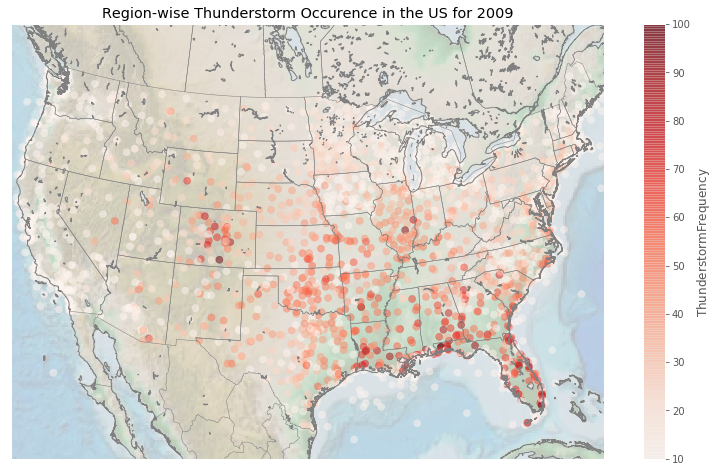

In [20]:
#@title Thunderstorm Region-wise
#Thunderstorm count on Map - get thunderstorm count for all stations a year - suppose 2009
year_chosen = year.value
#I already have filtered tables for US state
stn_thunder_count = spark.sql("SELECT stn, SUM(thunder) AS thunder_count FROM gsod_data_{} GROUP BY stn".format(year_chosen))

#get lat and lon values for the stations
stations_1 = stations.withColumnRenamed("usaf","stn")
stn_thunder_count = stn_thunder_count.join(stations_1, on = "stn", how= "inner")
stn_thunder_count = stn_thunder_count.select('stn', 'thunder_count', 'lat', 'lon')
stn_thunder_count_pd = stn_thunder_count.toPandas()
stn_thunder_count_pd.describe()

#Plot starts here
lat = stn_thunder_count_pd['lat'].values
lon = stn_thunder_count_pd['lon'].values
count_thunder = stn_thunder_count_pd['thunder_count'].values

# 1. Draw the map background
fig = plt.figure(figsize=(14, 8))
m = Basemap(projection='lcc', resolution='h',llcrnrlon=-119,llcrnrlat=22,urcrnrlon=-64,urcrnrlat=49, 
          lat_0=45, lon_0=-100)
m.etopo(scale=0.5, alpha=0.2)
# m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')
# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(lon, lat, latlon=True,
          c=count_thunder, s=50, cmap='Reds', alpha=0.5)
plt.colorbar(label=r'${\rm Thunderstorm Frequency}$')
plt.clim(10, 100)
plt.title("Region-wise Thunderstorm Occurence in the US for {}".format(year_chosen))
plt.show()

# **Insights**

*   More thunderstorms in southeast regions
*   The coastal areas in the southeast and some areas inColorado have higher likelihood of thunder as the stations inthose areas shown by dark red color.

